In [35]:
import pandas as pd
from ollama import chat
from ollama import ChatResponse
from tqdm import tqdm

In [36]:
X = pd.read_csv('2X_test_finetuning.csv')
y = pd.read_csv('2y_test_finetuning.csv')

In [37]:
X['Neutralized SMILES'][1]

'NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3c(c2)CCO3)C1'

In [38]:
df = pd.concat([X, y], axis = 1)

In [8]:
df

,Neutralized SMILES,ATC Codes
0,Cc1ncc(COC(=O)CCC(=O)OCCN(C)C)c(CO)c1O,N06BX
1,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3...,G04BD
2,C/C(O)=N\\c1ccc(O)cc1,N02BE
3,CC1(C(=O)O)CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(O...,R02AA
4,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,P02CA
...,...,...
713,C[C@@](O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#...,L02BB
714,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)nc21,J01MA
715,CC(=O)N[C@@H](CC(=O)N[C@@H](CCC(=O)O)C(=O)O)C(...,R01AC; S01GX
716,C[C@@H]1C[C@@H](OC(=O)c2cccnc2)CC(C)(C)C1,C04AC


In [9]:
s_smiles = X['Neutralized SMILES'][1]
response: ChatResponse = chat(
    model='gemma-2finetuned', 
    messages=[{"role": "user", "content": s_smiles}],#N06BX 
)
print(response['message']['content'])

A12AA; A12BD; A12CG


In [10]:
if "predicted_atc4" not in df.columns:
    df["predicted_atc4"] = None
import asyncio
from ollama import AsyncClient

async def chat(message):
    response = await AsyncClient().chat(model='gemma-2finetuned', messages=message)
    return response['message']['content']

for i in range(len(df)):
    smiles = df.at[i, "Neutralized SMILES"]
    message=[
        {"role": "user", "content": s_smiles}
    ]
    try:
      pred = await chat(message)
    except ollama.ResponseError as e:
      print('Error:', e.error)
      if e.status_code == 404:
        ollama.pull(model)
    print(pred)
    df.at[i, "predicted_atc4"] = pred

    if i % 10 == 0:
        df.to_csv("2finetuned_predicted_atc4_partial.csv", index=False)
        print("Guardado parcial")

df.to_csv("2finetuned_predicted_atc4.csv", index=False)

J05AE; J05AR
Guardado parcial
A07AA; A11BA; A12CC; G03AA
L01AA
J05AX; J05AH; R06AA
A07AA
L01AX; L01XA
A10BX
L01AD; L01AE; L01AF; S01XA
N02AF; R06AX
A08AB
H02BB
Guardado parcial
A03DA; A03DB
A07AA
A10BA; A10BB; A10BC; A11AA; N07CC
A10AD; A10AK
A07AA; A07AB; J05AX
H01AE
A10BX; A10BM
A07AA; A11EF; L04AX; L04XA
L01BA
J01MA; J01MB
Guardado parcial
A10BA; D06AX; S01EA
A10BX
A10AX; A10XX
J01AA
A10BX; A10BB
A10BA; L01AA
D07AC; L04AB
L01BC
L01AE
A10AX; A10CC; A11AA; L01AB; L04BA; N07BA; R06AB; S01XA; S01XX
Guardado parcial
J05AF; J05AR; J05BA; J05BB; N06AX
A07EB
L01AX; L02AH
A10BH
A10AX; D07BA; G01AD
A10BA; A10BB; A10BX
A08AA
J05AB; J05AF
G03AX
A01AD
Guardado parcial
J05AE; J05AR; J05CA
D10AA; L01AX; S01XA; S01XX
A10BA; A10BC; J05AH; S01XA
A10BB
A01AC; J01CA; J01CR; J01CR
D10AC; R06AA
M01AC; N05BC
L01EB
J05AK
A10AX; A10XB
Guardado parcial
B01AB
A10BA; A10BB
A01AA
A10BA; A10BX
A02BC; J01MA; J01MB; J01MF
J05AB
L01BB; L01XB
A10BB; A10BA
A10BX
L01AB
Guardado parcial
J01CA; J01CR; J01CR; J01CR
H02AA

In [4]:
preds = pd.read_csv('2finetuned_predicted_atc4.csv')
preds = preds['predicted_atc4']

In [5]:
preds

0                    J05AE; J05AR
1      A07AA; A11BA; A12CC; G03AA
2                           L01AA
3             J05AX; J05AH; R06AA
4                           A07AA
                  ...            
713                         A01AA
714    D07AE; G01CA; N05AF; N05AB
715                  G01AB; R06AA
716                  H05AF; H05AR
717                  L01AB; J05AB
Name: predicted_atc4, Length: 718, dtype: object

In [6]:
# Convert a string that simulates a list to a real list
def convert_string_list(element):
    # Delete [] of the string
    element = element[0:len(element)]
    # Create a list that contains each code as e.g. 'A'
    ATC_list = list(element.split('; '))
    for index, code in enumerate(ATC_list):
        # Delete '' of the code
        ATC_list[index] = code[0:len(code)]
    return ATC_list

In [7]:
clear_preds = []
for i, pred in enumerate(preds):
    preds_list = convert_string_list(pred)
    clear_preds_i = []
    for p in preds_list:
        if len(p) == 5:
            if p[0].isalpha():
                if p[1:3].isnumeric():
                    if p[3].isalpha():
                        if p[4].isalpha():
                            clear_preds_i.append(p)
                        else:
                            clear_preds_i.append("Invalid prediction")
                    else:
                        clear_preds_i.append("Invalid prediction")
                else:
                    clear_preds_i.append("Invalid prediction")    
            else:
                clear_preds_i.append("Invalid prediction")
        else:
            clear_preds_i.append("Invalid prediction")
    clear_preds.append(clear_preds_i)
clear_preds

[['J05AE', 'J05AR'],
 ['A07AA', 'A11BA', 'A12CC', 'G03AA'],
 ['L01AA'],
 ['J05AX', 'J05AH', 'R06AA'],
 ['A07AA'],
 ['L01AX', 'L01XA'],
 ['A10BX'],
 ['L01AD', 'L01AE', 'L01AF', 'S01XA'],
 ['N02AF', 'R06AX'],
 ['A08AB'],
 ['H02BB'],
 ['A03DA', 'A03DB'],
 ['A07AA'],
 ['A10BA', 'A10BB', 'A10BC', 'A11AA', 'N07CC'],
 ['A10AD', 'A10AK'],
 ['A07AA', 'A07AB', 'J05AX'],
 ['H01AE'],
 ['A10BX', 'A10BM'],
 ['A07AA', 'A11EF', 'L04AX', 'L04XA'],
 ['L01BA'],
 ['J01MA', 'J01MB'],
 ['A10BA', 'D06AX', 'S01EA'],
 ['A10BX'],
 ['A10AX', 'A10XX'],
 ['J01AA'],
 ['A10BX', 'A10BB'],
 ['A10BA', 'L01AA'],
 ['D07AC', 'L04AB'],
 ['L01BC'],
 ['L01AE'],
 ['A10AX',
  'A10CC',
  'A11AA',
  'L01AB',
  'L04BA',
  'N07BA',
  'R06AB',
  'S01XA',
  'S01XX'],
 ['J05AF', 'J05AR', 'J05BA', 'J05BB', 'N06AX'],
 ['A07EB'],
 ['L01AX', 'L02AH'],
 ['A10BH'],
 ['A10AX', 'D07BA', 'G01AD'],
 ['A10BA', 'A10BB', 'A10BX'],
 ['A08AA'],
 ['J05AB', 'J05AF'],
 ['G03AX'],
 ['A01AD'],
 ['J05AE', 'J05AR', 'J05CA'],
 ['D10AA', 'L01AX', 'S01XA', '

In [8]:
print(clear_preds.count("Invalid prediction"))
print(len(clear_preds)-clear_preds.count("Invalid prediction"))

0
718


In [9]:
import matplotlib.pyplot as plt
from collections import defaultdict
# Create a dictionary of integers
counter = defaultdict(int)

for pred in clear_preds:
    # ATC_level1_list = convert_string_list(row['ATC_level1'])
    for p in pred:
        if p != "Invalid prediction":
            counter[p] += 1
counter

defaultdict(int,
            {'J05AE': 6,
             'J05AR': 13,
             'A07AA': 24,
             'A11BA': 4,
             'A12CC': 1,
             'G03AA': 2,
             'L01AA': 43,
             'J05AX': 20,
             'J05AH': 23,
             'R06AA': 20,
             'L01AX': 11,
             'L01XA': 2,
             'A10BX': 40,
             'L01AD': 6,
             'L01AE': 9,
             'L01AF': 7,
             'S01XA': 18,
             'N02AF': 1,
             'R06AX': 15,
             'A08AB': 4,
             'H02BB': 1,
             'A03DA': 1,
             'A03DB': 1,
             'A10BA': 41,
             'A10BB': 34,
             'A10BC': 14,
             'A11AA': 5,
             'N07CC': 1,
             'A10AD': 3,
             'A10AK': 1,
             'A07AB': 11,
             'H01AE': 2,
             'A10BM': 1,
             'A11EF': 1,
             'L04AX': 6,
             'L04XA': 1,
             'L01BA': 11,
             'J01MA': 10,
             'J01

In [10]:
len(counter)

432

In [16]:
# Create a dictionary of integers
counter_preds = defaultdict(int)
for pred in clear_preds:
    # ATC_level1_list = convert_string_list(row['ATC_level1'])
    counter_preds[len(pred)] += 1
print(counter_preds)

defaultdict(<class 'int'>, {2: 206, 4: 49, 1: 342, 3: 79, 5: 19, 9: 6, 6: 11, 10: 2, 7: 2, 8: 1, 13: 1})


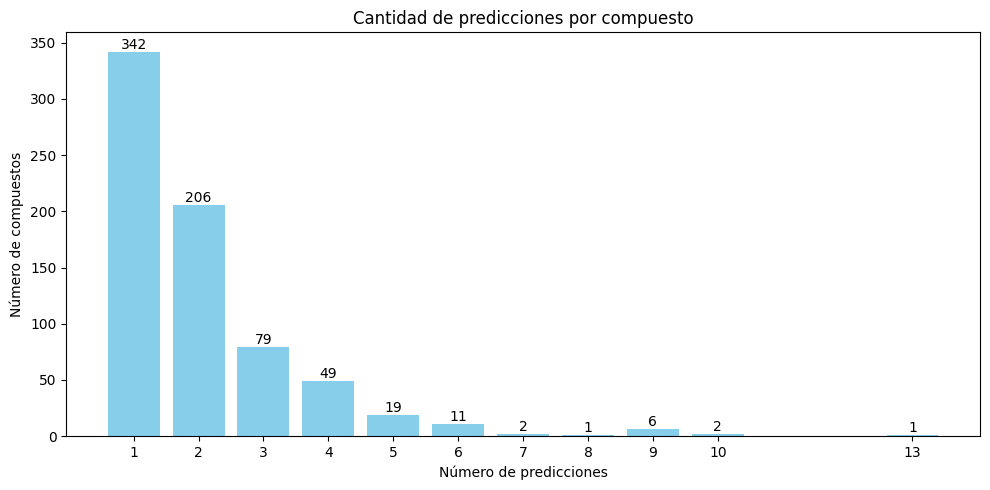

In [25]:
dict_preds = dict(sorted(counter_preds.items()))

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

codes = list(dict_preds.keys())
counts = list(dict_preds.values())

p = ax.bar(codes, counts, color='skyblue')
ax.bar_label(p)
ax.set_xticks(codes)
plt.title('Cantidad de predicciones por compuesto')
plt.xlabel('Número de predicciones')
plt.ylabel('Número de compuestos')
plt.tight_layout()

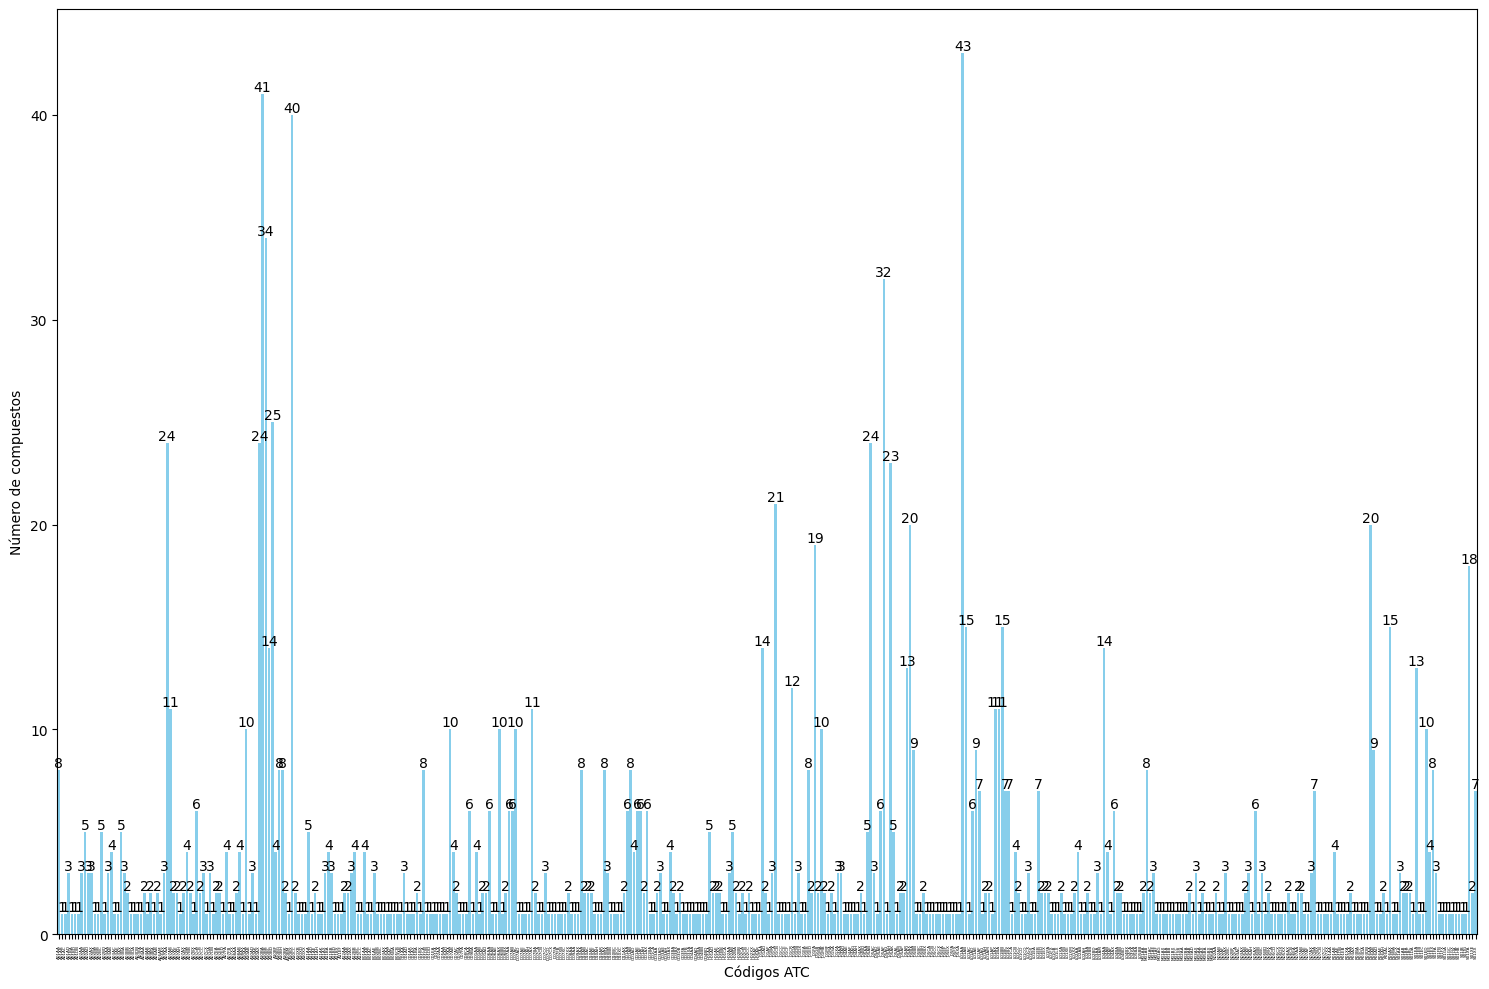

In [58]:
dict_level1 = dict(sorted(counter.items()))

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
codes = list(dict_level1.keys())
counts = list(dict_level1.values())
x_pos = list(range(len(codes)))

p = ax.bar(x_pos, counts, color='skyblue', width=0.8)
ax.bar_label(p)
plt.subplots_adjust(left=0.03, right=0.97)
plt.xlabel('Códigos ATC')
plt.ylabel('Número de compuestos')
labels = list(dict_level1.keys())
# step = 1  # Mostrará 1 de cada 5 códigos, ajustá este número según necesidad
half_width = 0.8 / 2
ax.set_xlim(min(x_pos) - half_width, max(x_pos) + half_width)
# ax.set_xticks(range(0, len(labels), step))
ax.set_xticks(x_pos)
ax.set_xticklabels(labels[::step], rotation=90, fontsize=3)
plt.tight_layout()
plt.show()

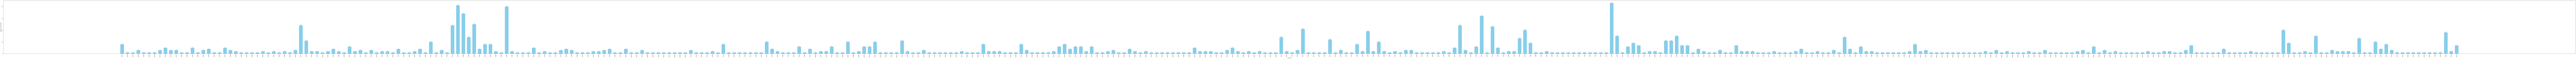

In [53]:
import matplotlib.pyplot as plt

dict_level1 = dict(sorted(counter.items()))

codes = list(dict_level1.keys())
counts = list(dict_level1.values())

# Generar posiciones X más separadas (por ejemplo, con un paso de 1.5)
spacing = 1.5
x_pos = [i * spacing for i in range(len(codes))]

fig, ax = plt.subplots(figsize=(len(codes), 10))  # Ajusta ancho al número de barras

# Dibujar las barras con separación
p = ax.bar(x_pos, counts, color='skyblue', width=1)  # width = 1 para que haya separación

# Etiquetas alineadas a las posiciones
ax.set_xticks(x_pos)
ax.set_xticklabels(codes, rotation=90)

# Etiquetas y título
ax.bar_label(p)
plt.xlabel('ATC code')
plt.ylabel('Number of compounds')
plt.tight_layout()
plt.show()


In [22]:
for i, pred in enumerate(clear_preds):
    if pred == "Invalid prediction":
        print(pred)

In [39]:
def precision(output_beam2, df_test):
    total_compounds = len(df_test)
    # Initialize counters for total matches and valid comparisons at each level
    total_matches = [0, 0, 0, 0]
    valid_comparisons = [total_compounds] * 4 # Start with all compounds being valid for comparison at every level

    # Iterate through the predictions for each compound
    for i, list_preds in enumerate(output_beam2):
        true_codes = df_test['ATC Codes'].iloc[i]
        true_codes = convert_string_list(true_codes)
        num_preds = [len(list_preds)]*4
        level_matches = [0, 0, 0, 0]
        not_compared = [False, True, True, True]
        # Compare predicted codes with true codes
        for p in list_preds:
            match_found = [False, False, False, False]
            for true_code in true_codes:
                # Compare each level
                if p[0] == true_code[0]:
                    match_found[0] = True
                    if p[1:3] == true_code[1:3]:
                        match_found[1] = True
                        if p[3] == true_code[3]:
                            match_found[2] = True
                            if p[4] == true_code[4]:
                                match_found[3] = True
            for level in range(4):
                if match_found[level]:
                    # If at least one time it can compare with level y+1 so it converts to False
                    # Level y has matched so it compares to level y+1
                    level_matches[level] += 1
                    if level+1 < 4:
                        not_compared[level+1] = False
                else:
                     if level+1 < 4:
                        num_preds[level+1] -= 1
        valid_comparisons = [valid_comparisons[level] - int(not_compared[level]) for level in range(4)]
        total_matches = [total_matches[level] + ((level_matches[level]/num_preds[level]) if num_preds[level] > 0 else 0) for level in range(4)]
        
    precisions = [total_matches[level] / valid_comparisons[level] if valid_comparisons[level] > 0 else 0 for level in range(4)]
    
    precision_1 = precisions[0] * 100
    precision_2 = precisions[1] * 100
    precision_3 = precisions[2] * 100
    precision_4 = precisions[3] * 100
    return precision_1, precision_2, precision_3, precision_4

In [40]:
def recall(output_beam2, df_test):
    # Load test dataset and initialize counters
    total_compounds = len(df_test)
    # Initialize counters for total matches and valid comparisons at each level
    total_matches = [0, 0, 0, 0]
    valid_comparisons = [total_compounds] * 4 # Start with all compounds being valid for comparison at every level

    # Iterate through the predictions for each compound
    for i, list_preds in enumerate(output_beam2):
        true_codes = df_test['ATC Codes'].iloc[i]
        true_codes = convert_string_list(true_codes)
        num_true_codes = [len(true_codes)]*4
        level_matches = [0, 0, 0, 0]
        not_compared = [False, True, True, True]
        # Compare true codes with predicted codes
        for true_code in true_codes:
            match_found = [False, False, False, False]
            for p in list_preds:
                # Compare each level
                if p[0] == true_code[0]:
                    match_found[0] = True
                    if p[1:3] == true_code[1:3]:
                        match_found[1] = True
                        if p[3] == true_code[3]:
                            match_found[2] = True
                            if p[4] == true_code[4]:
                                match_found[3] = True
            for level in range(4):
                if match_found[level]:
                    # If at least one time it can compare with level y+1 so it converts to False
                    # Level y has matched so it compares to level y+1
                    level_matches[level] += 1
                    if level+1 < 4:
                        not_compared[level+1] = False
                else:
                    if level+1 < 4:
                        num_true_codes[level+1] -= 1
        # For compound x it couldn't compare at level i so it has to decrease the amount of comparisons at level i for compound x
        valid_comparisons = [valid_comparisons[level] - int(not_compared[level]) for level in range(4)]
        total_matches = [total_matches[level] + ((level_matches[level]/num_true_codes[level]) if num_true_codes[level] > 0 else 0) for level in range(4)]
        
    recalls = [(total_matches[level] / valid_comparisons[level]) if valid_comparisons[level] > 0 else 0 for level in range(4)]
    
    recall_1 = recalls[0] * 100
    recall_2 = recalls[1] * 100
    recall_3 = recalls[2] * 100
    recall_4 = recalls[3] * 100
    return recall_1, recall_2, recall_3, recall_4

In [41]:
clear_preds[1]

['A07AA', 'A11BA', 'A12CC', 'G03AA']

In [42]:
df

,Neutralized SMILES,ATC Codes
0,Cc1ncc(COC(=O)CCC(=O)OCCN(C)C)c(CO)c1O,N06BX
1,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3...,G04BD
2,C/C(O)=N\\c1ccc(O)cc1,N02BE
3,CC1(C(=O)O)CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(O...,R02AA
4,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,P02CA
...,...,...
713,C[C@@](O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#...,L02BB
714,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)nc21,J01MA
715,CC(=O)N[C@@H](CC(=O)N[C@@H](CCC(=O)O)C(=O)O)C(...,R01AC; S01GX
716,C[C@@H]1C[C@@H](OC(=O)c2cccnc2)CC(C)(C)C1,C04AC


In [43]:
precision_1, precision_2, precision_3, precision_4 = precision(clear_preds, df)
recall_1, recall_2, recall_3, recall_4 = recall(clear_preds, df)

In [44]:
print(f"Precision level 1: {precision_1}")
print(f"Precision level 2: {precision_2}")
print(f"Precision level 3: {precision_3}")
print(f"Precision level 4: {precision_4}")

Precision level 1: 10.66542865985763
Precision level 2: 25.0
Precision level 3: 41.358024691358025
Precision level 4: 2.564102564102564


In [45]:
print(f"Recall level 1: {recall_1}")
print(f"Recall level 2: {recall_2}")
print(f"Recall level 3: {recall_3}")
print(f"Recall level 4: {recall_4}")

Recall level 1: 12.086815227483749
Recall level 2: 26.237623762376238
Recall level 3: 46.2962962962963
Recall level 4: 7.6923076923076925


In [46]:
def metrics_calc(output_beam2, df_test):
    precisions = []
    recalls = []
    f1s = []
    from sklearn import metrics
    for i, preds in enumerate(output_beam2):
        ground_truth = convert_string_list(df_test['ATC Codes'].iloc[i])
        binary_predictions = []
        binary_ground_truth = []
        print(ground_truth)
        print(preds)
        set_pred_gt = list(set(preds + ground_truth))
        print(set_pred_gt)
        for code in set_pred_gt:
            if code in preds:
                binary_predictions.append(1)
            else:
                binary_predictions.append(0)
            if code in ground_truth:
                binary_ground_truth.append(1)
            else:
                binary_ground_truth.append(0)    
        print(binary_ground_truth)
        print(binary_predictions)
        precisions.append(metrics.precision_score(binary_ground_truth, binary_predictions, zero_division=0))
        recalls.append(metrics.recall_score(binary_ground_truth, binary_predictions))
        f1s.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    return precisions, recalls, f1s

In [47]:
precisions, recalls, f1s = metrics_calc(clear_preds, df)

['N06BX']
['J05AE', 'J05AR']
['J05AE', 'N06BX', 'J05AR']
[0, 1, 0]
[1, 0, 1]
['G04BD']
['A07AA', 'A11BA', 'A12CC', 'G03AA']
['A12CC', 'A11BA', 'A07AA', 'G03AA', 'G04BD']
[0, 0, 0, 0, 1]
[1, 1, 1, 1, 0]
['N02BE']
['L01AA']
['L01AA', 'N02BE']
[0, 1]
[1, 0]
['R02AA']
['J05AX', 'J05AH', 'R06AA']
['J05AX', 'R06AA', 'J05AH', 'R02AA']
[0, 0, 0, 1]
[1, 1, 1, 0]
['P02CA']
['A07AA']
['P02CA', 'A07AA']
[1, 0]
[0, 1]
['M02AA']
['L01AX', 'L01XA']
['M02AA', 'L01XA', 'L01AX']
[1, 0, 0]
[0, 1, 1]
['D01AE']
['A10BX']
['D01AE', 'A10BX']
[1, 0]
[0, 1]
['J01AA']
['L01AD', 'L01AE', 'L01AF', 'S01XA']
['J01AA', 'L01AE', 'L01AF', 'L01AD', 'S01XA']
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 1]
['R01AD']
['N02AF', 'R06AX']
['R01AD', 'N02AF', 'R06AX']
[1, 0, 0]
[0, 1, 1]
['G03CB']
['A08AB']
['A08AB', 'G03CB']
[0, 1]
[1, 0]
['R07AB']
['H02BB']
['R07AB', 'H02BB']
[1, 0]
[0, 1]
['N04CX']
['A03DA', 'A03DB']
['A03DB', 'A03DA', 'N04CX']
[0, 0, 1]
[1, 1, 0]
['R06AE']
['A07AA']
['A07AA', 'R06AE']
[0, 1]
[1, 0]
['A01AC', 'R01AD', 'R03

In [48]:
f1s

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [49]:
precisions_average = sum(precisions)/len(precisions)
recalls_average = sum(recalls)/len(recalls)
f1s_average = sum(f1s)/len(f1s)

In [50]:
print(precisions_average)
print(recalls_average)
print(f1s_average)

0.0002785515320334262
0.001392757660167131
0.0004642525533890436
